In [1]:
from Research_Final.DatasetLoader_mine2 import DatasetLoader
import os
import numpy as np

In [2]:
parent = 'multipletimeseriesforecasting/preprocessed-data/'

path = os.path.join(parent, 'SanFranciscoTraffic/traffic_weekly_dataset.tsf')

dl = DatasetLoader('SanFranciscoTraffic', path)

matrix_1_original = dl.dataset_load_and_preprocess("original")
matrix_1_norm = dl.dataset_load_and_preprocess("normalized")
print(matrix_1_norm.shape)

---------------------------------------------------
Dataset name:  SanFranciscoTraffic
Dataset contains missing values?  False
--------------------------
---------------------------------------------------
Dataset name:  SanFranciscoTraffic
Dataset contains missing values?  False
--------------------------
(862, 104)


In [5]:
matrix_1_norm.shape

(862, 104)

#### Choosing the same cluster :( with Rolling Window on 80% of TS

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity

from scipy.special import softmax

import time

d = 10000
models = 8

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_NonLinear_Sin(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_NonLinear_Sin, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)

    def encode(self, x): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return functional.hard_quantize(sample_hv)

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        return center
        

    def forward(self, x):
        enc = torch.reshape(self.encode(x), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions

In [10]:
model = MultiModel_With_NonLinear_Sin(2, 40) # 1 class, 5

# Model training

start_time = time.time()
#main()
#print("--- %s seconds ---" % (time.time() - start_time))
ts_cut = int(matrix_1_original.shape[0]*0.8)
centers = {}

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in range(1): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for n in tqdm(range(ts_cut)): # For the first 80 ts
            pred = []
            ts = matrix_1_original[n,:] # Get the ts
            center = []
            for i in range(len(ts)-40): # For all the samples
                label = torch.tensor(ts[i+40])
                sample = torch.tensor(ts[i:i+40])
                samples_hv = model.encode(sample) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                center.append(model.model_update(samples_hv, label)) # Pass input and label to train
            centers[n] = center

        #print(f"Training mean squared error of {(mse.compute().item()):.3f}")

100%|██████████| 689/689 [01:56<00:00,  5.91it/s]

Training mean squared error of nan



d:\Aplicaciones\Anaconda\envs\tensorflow_env\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: The ``compute`` method of metric MeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)


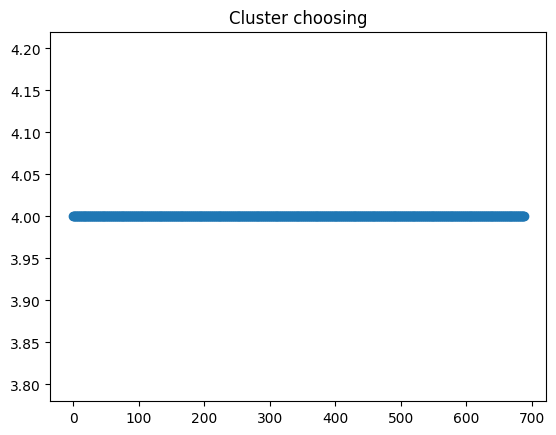

In [35]:
import matplotlib.pyplot as plt

y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

#### Changing to normalized doesn't fix the issue of choosing the same cluster

In [36]:
model = MultiModel_With_NonLinear_Sin(2, 40) # 1 class, 5

# Model training

ts_cut = int(matrix_1_norm.shape[0]*0.8)
centers = {}

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in range(1): # Number of iterations for all the samples
        for n in tqdm(range(ts_cut)): # For the first 80 ts
            pred = []
            ts = matrix_1_norm[n,:] # Get the ts
            center = []
            for i in range(len(ts)-40): # For all the samples
                label = torch.tensor(ts[i+40])
                sample = torch.tensor(ts[i:i+40])
                samples_hv = model.encode(sample) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                center.append(model.model_update(samples_hv, label)) # Pass input and label to train
            centers[n] = center

        #print(f"Training mean squared error of {(mse.compute().item()):.3f}")

100%|██████████| 689/689 [01:43<00:00,  6.66it/s]


In [37]:
len(centers)

689

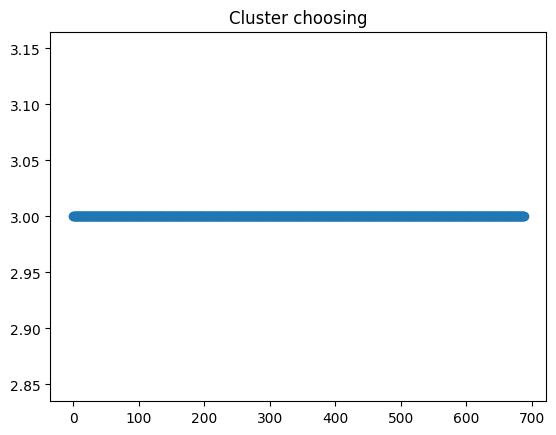

In [38]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

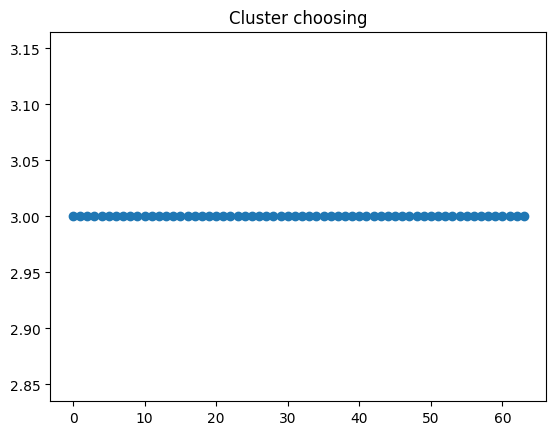

In [44]:
plt.title("Cluster choosing")
plt.plot(centers[0], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

#### If we choose diffrent timestamp and all the time series

In [56]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.4), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60
 17 55 53 48 33 51 31 59] [13 22 32 30 46 23  4 14 29]


In [58]:
sets_training.sort()
sets_training

array([ 2,  3, 10, 17, 19, 21, 24, 26, 27, 31, 33, 34, 35, 36, 38, 39, 40,
       41, 44, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 62])

In [66]:
model = MultiModel_With_NonLinear_Sin(2, 40) # 1 class, 5

centers = {}

for i in tqdm(sets_training):
    pred = []
    samples = matrix_1_original[:, i:i+40]
    labels = matrix_1_original[:, i+40]
    
    for n in range(samples.shape[0]):
        if (n not in centers.keys()):
            centers[n] = []
        label = torch.tensor(labels[n])
        sample = torch.tensor(samples[n, :])

        samples_hv = model.encode(sample) # Encode the inputs

        centers[n].append(model.model_update(samples_hv, label)) # Pass input and label to train

100%|██████████| 32/32 [01:04<00:00,  2.00s/it]


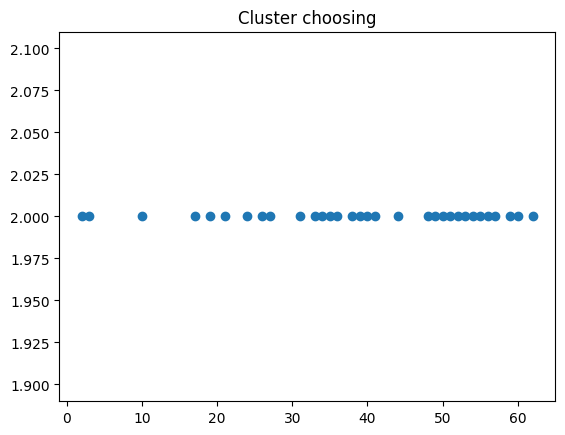

In [67]:
plt.title("Cluster choosing")
plt.plot(sets_training, centers[3], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

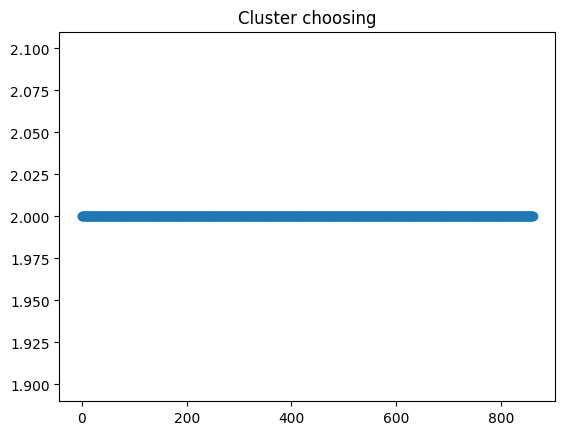

In [68]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

#### Sets not sorted

In [71]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.4), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

model = MultiModel_With_NonLinear_Sin(2, 40) # 1 class, 5

centers = {}

for i in tqdm(sets_training):
    pred = []
    samples = matrix_1_norm[:, i:i+40]
    labels = matrix_1_norm[:, i+40]
    
    for n in range(samples.shape[0]):
        if (n not in centers.keys()):
            centers[n] = []
        label = torch.tensor(labels[n])
        sample = torch.tensor(samples[n, :])

        samples_hv = model.encode(sample) # Encode the inputs

        centers[n].append(model.model_update(samples_hv, label)) # Pass input and label to train

[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60
 17 55 53 48 33 51 31 59] [13 22 32 30 46 23  4 14 29]


100%|██████████| 32/32 [01:03<00:00,  1.99s/it]


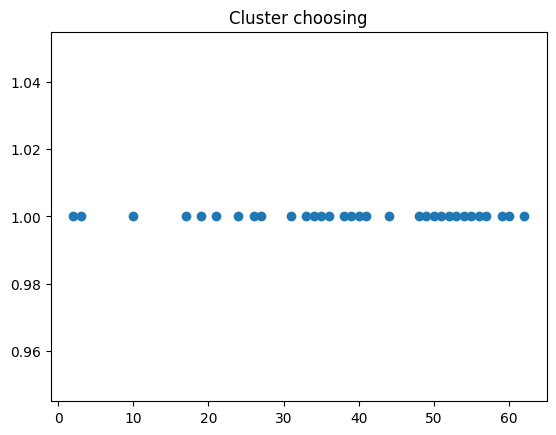

In [72]:
plt.title("Cluster choosing")
plt.plot(sets_training, centers[3], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

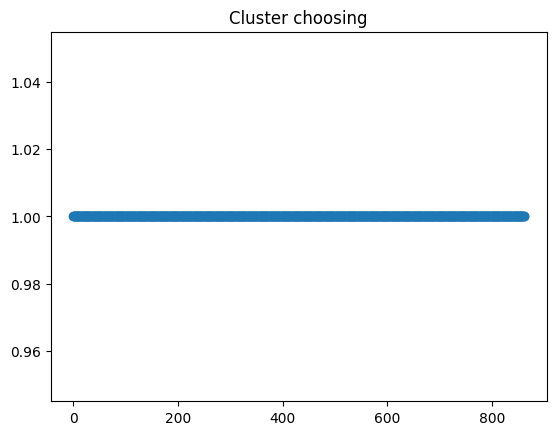

In [73]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

## CONLCUSION = Clusters not working

#### LETS MODIFY by adding Time Series it's coming from

In [76]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity, bind

from scipy.special import softmax

import time

d = 10000
models = 8
ts = matrix_1_norm.shape[0]

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_Data(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_Data, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)
        self.time_series = functional.random_hv(ts, d) # Whic sensor it comes from

    def encode(self, x, ts): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return bind(functional.hard_quantize(sample_hv), self.time_series[ts])

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        return center
        

    def forward(self, x):
        enc = torch.reshape(self.encode(x), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions

In [77]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.4), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

model = MultiModel_With_Data(2, 40) # 1 class, 5

centers = {}

for i in tqdm(sets_training):
    pred = []
    samples = matrix_1_norm[:, i:i+40]
    labels = matrix_1_norm[:, i+40]
    
    for n in range(samples.shape[0]):
        if (n not in centers.keys()):
            centers[n] = []
        label = torch.tensor(labels[n])
        sample = torch.tensor(samples[n, :])

        samples_hv = model.encode(sample, n) # Encode the inputs

        centers[n].append(model.model_update(samples_hv, label)) # Pass input and label to train

[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60
 17 55 53 48 33 51 31 59] [13 22 32 30 46 23  4 14 29]


100%|██████████| 32/32 [01:04<00:00,  2.00s/it]


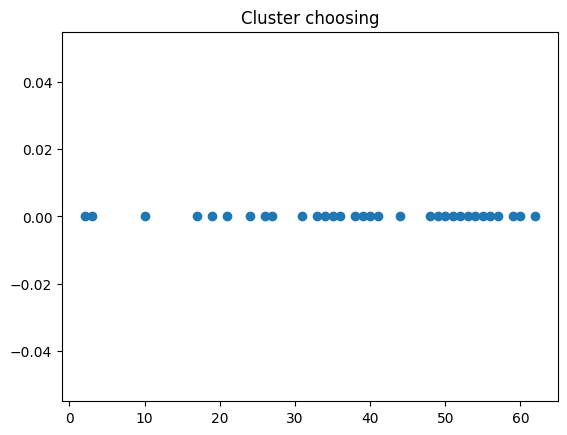

In [80]:
plt.title("Cluster choosing")
plt.plot(sets_training, centers[1], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

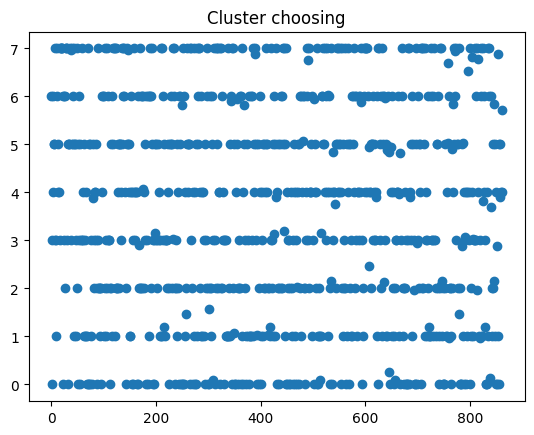

In [81]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

#### Lets try it with timeseries

In [91]:
ts = matrix_1_norm.shape[0]
model = MultiModel_With_Data(2, 40) # 1 class, 5

# Model training

ts_cut = int(matrix_1_original.shape[0]*0.8)
centers = {}

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in range(1): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for n in tqdm(range(ts_cut)): # For the first 80 ts
            pred = []
            ts = matrix_1_norm[n,:] # Get the ts
            center = []
            for i in range(len(ts)-40): # For all the samples
                label = torch.tensor(ts[i+40])
                sample = torch.tensor(ts[i:i+40])
                samples_hv = model.encode(sample, n) # Encode the inputs
               
                center.append(model.model_update(samples_hv, label)) # Pass input and label to train
            centers[n] = center

100%|██████████| 689/689 [01:48<00:00,  6.35it/s]


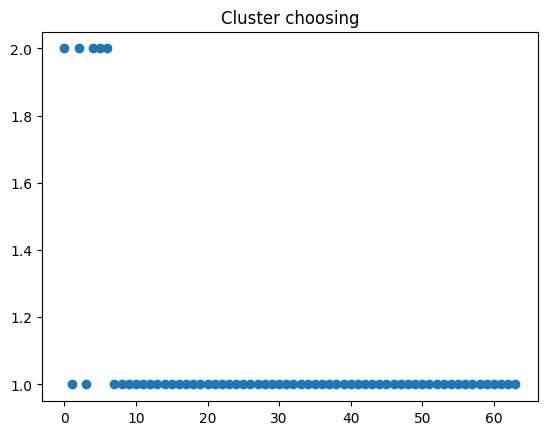

In [101]:
plt.title("Cluster choosing")
plt.plot(centers[201], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

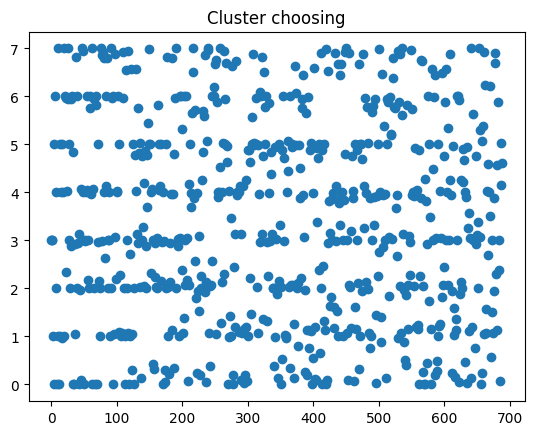

In [92]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

#### How you input the training data affects distribution

### Let's modify by adding time stamp

In [107]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity, bind

from scipy.special import softmax

import time

d = 10000
models = 8
time = matrix_1_norm.shape[1]

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_TimeStamp(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_TimeStamp, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)
        self.time_stamp = functional.level_hv(time, d)

    def encode(self, x, start_time): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return bind(functional.hard_quantize(sample_hv), self.time_stamp[start_time])

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        return center
        

    def forward(self, x):
        enc = torch.reshape(self.encode(x), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions

#### Normal Training

In [109]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.4), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

model = MultiModel_With_TimeStamp(2, 40) # 1 class, 5

centers = {}

for i in tqdm(sets_training):
    pred = []
    samples = matrix_1_norm[:, i:i+40]
    labels = matrix_1_norm[:, i+40]
    
    for n in range(samples.shape[0]):
        if (n not in centers.keys()):
            centers[n] = []
        label = torch.tensor(labels[n])
        sample = torch.tensor(samples[n, :])

        samples_hv = model.encode(sample, i) # Encode the inputs

        centers[n].append(model.model_update(samples_hv, label)) # Pass input and label to train

[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60
 17 55 53 48 33 51 31 59] [13 22 32 30 46 23  4 14 29]


100%|██████████| 32/32 [01:08<00:00,  2.15s/it]


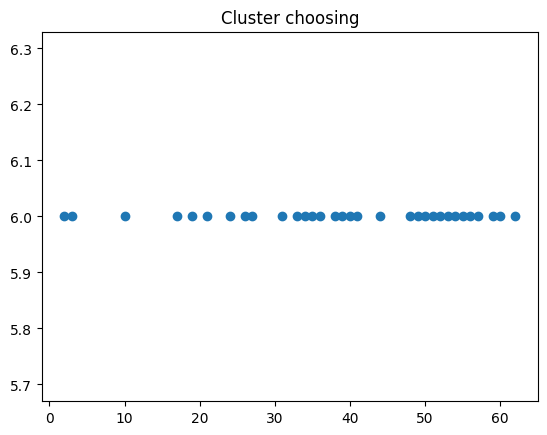

In [116]:
plt.title("Cluster choosing")
plt.plot(sets_training, centers[7], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

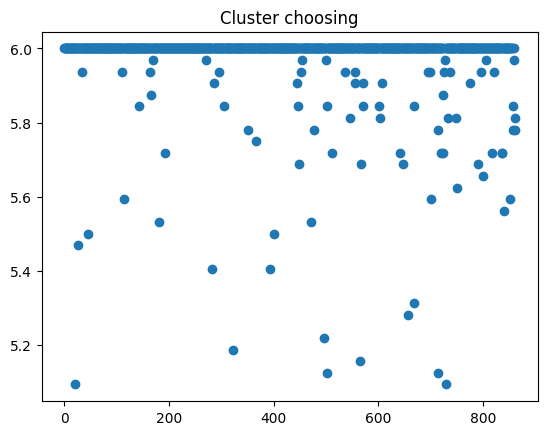

In [117]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

#### Training with full time series

In [119]:
ts = matrix_1_norm.shape[0]
model = MultiModel_With_TimeStamp(2, 40) # 1 class, 5

# Model training

ts_cut = int(matrix_1_original.shape[0]*0.8)
centers = {}

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in range(1): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for n in tqdm(range(ts_cut)): # For the first 80 ts
            pred = []
            ts = matrix_1_norm[n,:] # Get the ts
            center = []
            for i in range(len(ts)-40): # For all the samples
                label = torch.tensor(ts[i+40])
                sample = torch.tensor(ts[i:i+40])
                samples_hv = model.encode(sample, i) # Encode the inputs
               
                center.append(model.model_update(samples_hv, label)) # Pass input and label to train
            centers[n] = center

100%|██████████| 689/689 [01:46<00:00,  6.48it/s]


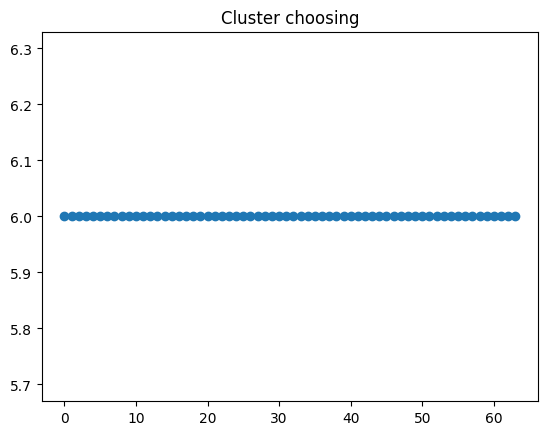

In [120]:
plt.title("Cluster choosing")
plt.plot(centers[201], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

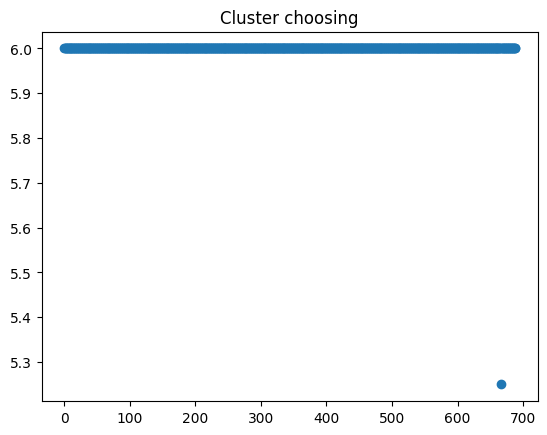

In [121]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

### Try combining both ideas?

In [64]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity, bind, bundle

from scipy.special import softmax

import time

d = 10000
models = 8
time = matrix_1_norm.shape[1]
ts = matrix_1_norm.shape[0]

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_TimeStamp_TimeSeries(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_TimeStamp_TimeSeries, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)
        time_stamp_array = functional.level_hv(time, d)
        self.time_stamp = {}
        for i in range(time):
            self.time_stamp[i] = time_stamp_array[i]
        time_series_array = functional.random_hv(ts, d)
        self.time_series = {}
        for i in range(ts):
            self.time_series[i] = time_series_array[i]


    def encode(self, x, start_time, ts): # encoding a value
        sum_hdv = torch.zeros(d)
        for i in range(len(x)):
            x[i] = float(x[i])
            enc = torch.pow(self.project(torch.tensor([x[i]])), 6*x[i])
            time_enc = functional.bind(functional.hard_quantize(enc), self.time_stamp[start_time + i])
            if i == 0:
                sum_hdv = time_enc
            else:
                sum_hdv = functional.bundle(sum_hdv, time_enc)
        return bind(sum_hdv, self.time_series[ts])

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x
        return center

    def forward(self, x):
        enc = torch.reshape(self.encode(x), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions

In [53]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.4), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

model = MultiModel_With_TimeStamp_TimeSeries(2, 1) # 1 class, 5

centers = {}

for i in tqdm(sets_training):
    pred = []
    samples = matrix_1_norm[:, i:i+40]
    labels = matrix_1_norm[:, i+40]
    
    for n in range(samples.shape[0]):
        if (n not in centers.keys()):
            centers[n] = []
        label = torch.tensor(labels[n])
        sample = torch.tensor(samples[n, :])

        samples_hv = model.encode(sample, i, n) # Encode the inputs

        centers[n].append(model.model_update(samples_hv, label)) # Pass input and label to train

[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60
 17 55 53 48 33 51 31 59] [13 22 32 30 46 23  4 14 29]


100%|██████████| 32/32 [15:19<00:00, 28.73s/it]


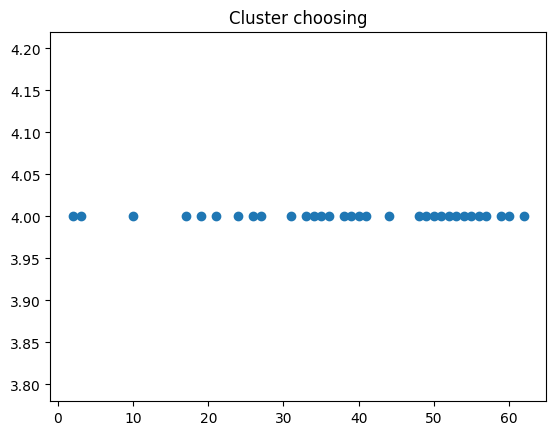

In [60]:
import matplotlib.pyplot as plt

plt.title("Cluster choosing")
plt.plot(sets_training, centers[250], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

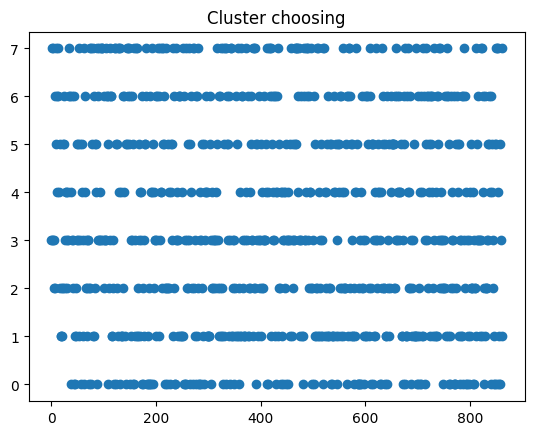

In [61]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

In [65]:
model = MultiModel_With_TimeStamp_TimeSeries(2, 1) # 1 class, 5

# Model training

ts_cut = int(matrix_1_original.shape[0]*0.8)
centers = {}

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in range(1): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for n in tqdm(range(ts_cut)): # For the first 80 ts
            pred = []
            ts = matrix_1_norm[n,:] # Get the ts
            center = []
            for i in range(len(ts)-40): # For all the samples
                label = torch.tensor(ts[i+40])
                sample = torch.tensor(ts[i:i+40])
                samples_hv = model.encode(sample, i, n) # Encode the inputs
               
                center.append(model.model_update(samples_hv, label)) # Pass input and label to train
            centers[n] = center

100%|██████████| 689/689 [23:42<00:00,  2.07s/it]


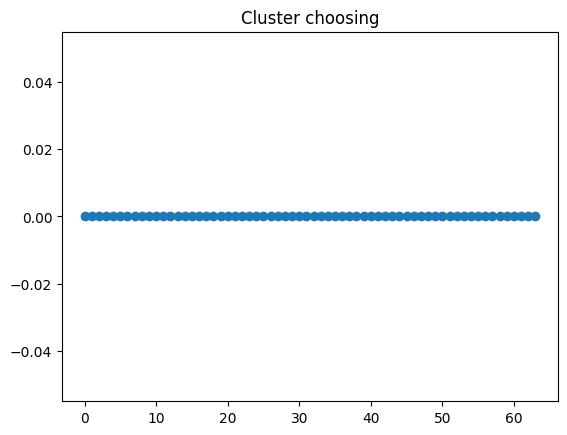

In [67]:
plt.title("Cluster choosing")
plt.plot(centers[0], "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

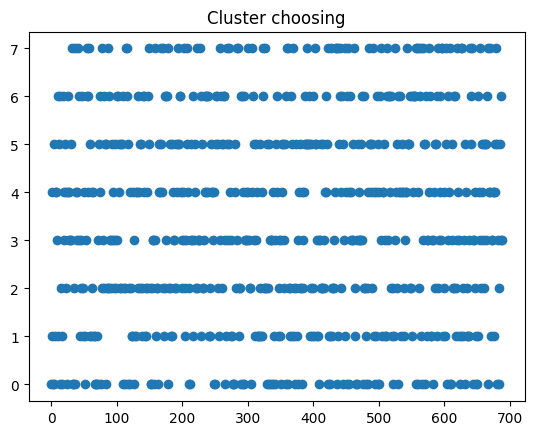

In [68]:
y = [np.mean(centers[i]) for i in range(len(centers))]

plt.title("Cluster choosing")
plt.plot(y, "o")
#plt.xlim(0,200)
#plt.xlim(0,200)
plt.show()

## No extra data

In [3]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.5), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

[24 39 52 27 44  2 21 62 41 50 38 54 35 26 57 49  3 40 36 10 56 19 34 60
 17 55 53 48 33 51 31 59 13 22 32 30 46 23  4 14 29] [28 42 58 47 18 63 20 25  6 45  7]


In [4]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity

from scipy.special import softmax

import time

d=10000
models = 8

# Model based on RegHD application for Single model regression -> No comparing which cluster
class MultiModel_With_NonLinear_Sin(nn.Module):
    def __init__(self, num_classes, size):
        super(MultiModel_With_NonLinear_Sin, self).__init__()

        self.lr = 0.00001 # alpha
        self.M = torch.zeros(models, d).double() # Model initializes in 0
        self.project = embeddings.Projection(size, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
        self.project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
        self.bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
        self.bias.data.uniform_(0, 2 * math.pi) # bias
        self.cluster = functional.random_hv(models, d)

    def encode(self, x): # encoding a value
        for i in range(len(x)):
            x[i] = float(x[i])
        enc = self.project(x)
        sample_hv = torch.cos(enc + self.bias) * torch.sin(enc) 
        return functional.hard_quantize(sample_hv)

    def model_update(self, x, y): # update # y = no hv
        x = torch.reshape(x, (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, x))) # Compare input with cluster
        model_result = F.linear(x, self.M).type(torch.FloatTensor)
        update = self.M + (float(self.lr) * float(y - F.linear(confidence, model_result)) * x) # Model + alpha*(Error)*(x)
        #update = update.mean(0) # Mean by columns
        self.M = update # New 
        # update cluster center?
        center = [num.item() for num in confidence[0]].index(max(confidence[0]).item())
        print(center)
        self.cluster[center] = self.cluster[center] + (1-max(confidence[0])) * x 
        # BASICALLY: K-means clustering with confidence instead of distance
        

    def forward(self, x):
        enc = torch.reshape(self.encode(x), (1,d))
        confidence = np.transpose(softmax(cos_similarity(self.cluster, enc))) # Compare input with cluster
        model_result = F.linear(enc, self.M).type(torch.FloatTensor)
        res = F.linear(confidence, model_result) # Multiply enc (x) * weights (Model) = Dot product
        return res # Return the resolutions
    
model = MultiModel_With_NonLinear_Sin(2, 40) # 1 class, 5
#model = model.to(device)

#mse = torchmetrics.MeanSquaredError()
    
# Model training

start_time = time.time()
#main()
#print("--- %s seconds ---" % (time.time() - start_time))

with torch.no_grad(): # disabled gradient calculation because were doing it manually
    for _ in tqdm(range(10)): # Number of iterations for all the samples
        mse = torchmetrics.MeanSquaredError()
        for i in sets_training:
            pred = []
            samples = matrix_1_original[:, i:i+40]
            labels = matrix_1_original[:, i+40]
            #print(f"sample: {samples}, label:{labels}")
            #samples = samples.to(device) # pass sample and label (1 at a time)
            #labels = labels.to(device)
            
            for n in range(samples.shape[0]):
                label = torch.tensor(labels[n])
                sample = torch.tensor(samples[n, :])
                #print(x)
                #samples = 
                samples_hv = model.encode(sample) # Encode the inputs
                #print(f"sample_hv:{samples_hv}")
                model.model_update(samples_hv, label) # Pass input and label to train

                predictions_testing = model(sample) # Pass samples from test to model (forward function)
                pred.append(predictions_testing[0])
                #predictions_testing = predictions_testing
                #label = label
                mse.update(predictions_testing[0], label.unsqueeze(dim=0))
                #mse.update(predictions_testing.cpu(), label)

        print(f"Training mean squared error of {(mse.compute().item()):.3f}")

  0%|          | 0/10 [00:00<?, ?it/s]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


 10%|█         | 1/10 [00:31<04:40, 31.16s/it]

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


 10%|█         | 1/10 [00:37<05:40, 37.79s/it]


KeyboardInterrupt: 

#### See Hypervectors and center with PCA

In [49]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

# Note: this example requires the torchmetrics library: https://torchmetrics.readthedocs.io
import torchmetrics
from tqdm import tqdm

from torchhd import functional
from torchhd import embeddings
from torchhd import cos_similarity

from scipy.special import softmax

import time

d=10000
models = 8
clusters = functional.random_hv(models, d)
hv_group = []
project = embeddings.Projection(40, d).double() # 5 features, 10000 dimensions = hypervectors like weights?
project.weight.data.normal_(0, 1) # Normal distributions mean=0.0, std=1.0
bias = nn.parameter.Parameter(torch.empty(d), requires_grad=False)
bias.data.uniform_(0, 2 * math.pi) # bias

def encode(x): # encoding a value
    for i in range(len(x)):
        x[i] = float(x[i])
    enc = project(x)
    sample_hv = torch.cos(enc + bias) * torch.sin(enc) 
    return functional.hard_quantize(sample_hv)

for i in tqdm(sets_training):
    pred = []
    samples = matrix_1_norm[:, i:i+40]
    labels = matrix_1_norm[:, i+40]
    
    for n in range(samples.shape[0]):
        label = torch.tensor(labels[n])
        sample = torch.tensor(samples[n, :])
        hv_group.append(encode(sample).numpy()) # Encode the inputs

100%|██████████| 119/119 [01:23<00:00,  1.43it/s]


In [50]:
from sklearn.decomposition import PCA
pca_clusters = PCA(n_components=2).fit(clusters).transform(clusters)

In [51]:
pca_hv = PCA(n_components=2).fit(hv_group).transform(hv_group)

#### This is PCA of San Francisco Traffic

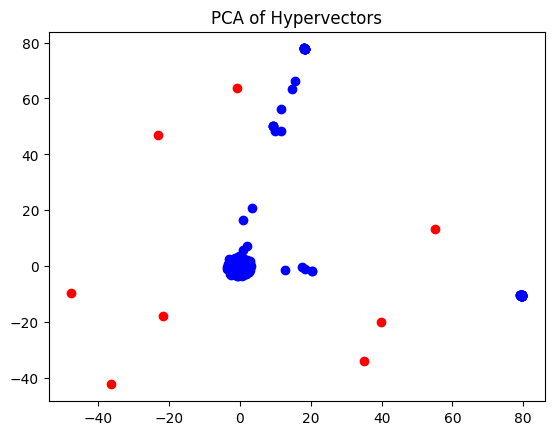

In [34]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

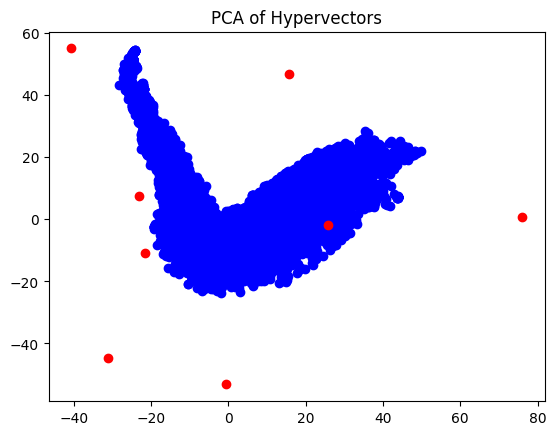

In [9]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

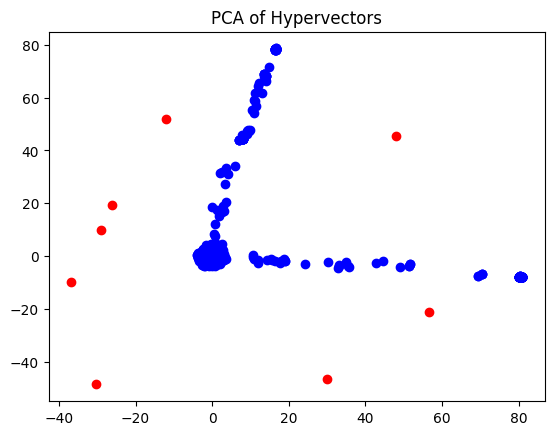

In [13]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

#### This is PCA of Electricity Load Diagrams

In [14]:
parent = 'multipletimeseriesforecasting/preprocessed-data/'

path = os.path.join(parent, 'ElectricityLoadDiagrams/electr_daily.csv')

dl = DatasetLoader('ElectricityLoadDiagrams', path)

matrix_1_original = dl.dataset_load_and_preprocess("original")
matrix_1_norm = dl.dataset_load_and_preprocess("normalized")
print(matrix_1_norm.shape)

---------------------------------------------------
Dataset name:  ElectricityLoadDiagrams
Dataset contains missing values?  False
--------------------------
---------------------------------------------------
Dataset name:  ElectricityLoadDiagrams
Dataset contains missing values?  False
--------------------------
(320, 1096)


In [18]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.1), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

[ 530  453  925  521  839  581  940  936  560   94  507  403   47  329
  528  154  495 1016  104  958  415  156  215  989   27  806  165  370
  298  756   41  762  605   78  509  935  836  481   80  997   35  808
  584   49   85  175  700  310  577  971  923  537  259  464  742  314
   60  186  683  148  135  747  301  236  573  534  593   65  538  281
 1036  241    6  541  770  120  436  335  691  191  207   90  589  961
  977  101  745] [ 180  870  999  661  877  311  612 1004  766  678   34  463  494 1029
  969  737  108  181  761   99  258  331]


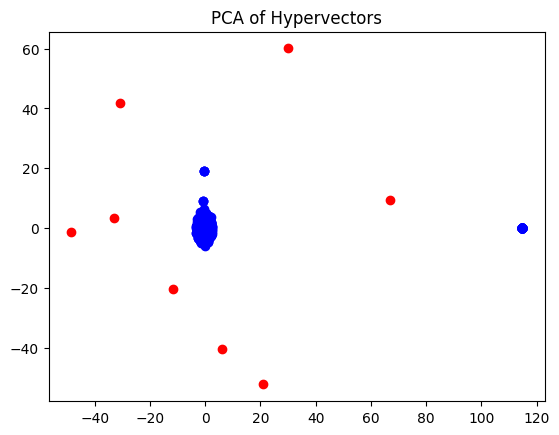

In [22]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

#### This is PCA of Energy Consumption Fraunhofer

In [24]:
parent = 'multipletimeseriesforecasting/preprocessed-data/'

path = os.path.join(parent, 'EnergyConsumptionFraunhofer/electrFraunhofer_daily.csv')

dl = DatasetLoader('EnergyConsumptionFraunhofer', path)

matrix_1_original = dl.dataset_load_and_preprocess("original")
matrix_1_norm = dl.dataset_load_and_preprocess("normalized")
print(matrix_1_norm.shape)

---------------------------------------------------
Dataset name:  EnergyConsumptionFraunhofer
Dataset contains missing values?  False
--------------------------
---------------------------------------------------
Dataset name:  EnergyConsumptionFraunhofer
Dataset contains missing values?  False
--------------------------
(314, 365)


In [27]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.3), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

[139 232 213 184 138  95 247 273   4 111 147  58 291 173 224   6  59 146
 279 312 206  18 125 161 105  92 122 238 299  11 300 256 278  85 179  65
 257 207 274 169  12  27 211 324  73  29  80 131 102 229 323  91 127 317
 322 187  89 119 186 290  90 158 249 313  14 233 263  51   9 112  16   0
 185 311  62 175 150 188  70 168 222  41 106 267 201 231 154] [ 39  93  78 208 230 307  17 244  88 159 163  42 132 172 162 177   5 214
 120  38 221 171]


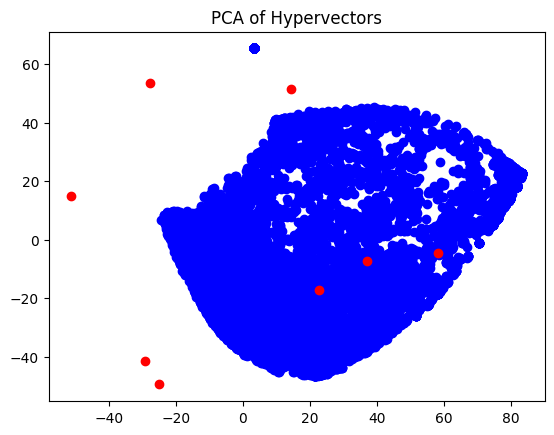

In [31]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

#### This is PCA of Guangzhou Traffic

In [32]:
parent = 'multipletimeseriesforecasting/preprocessed-data/'

path = os.path.join(parent, 'GuangzhouTraffic/traffic_speed_hourly.csv')

dl = DatasetLoader('GuangzhouTraffic', path)

matrix_1_original = dl.dataset_load_and_preprocess("original")
matrix_1_norm = dl.dataset_load_and_preprocess("normalized")
print(matrix_1_norm.shape)

---------------------------------------------------
Dataset name:  GuangzhouTraffic
Dataset contains missing values?  False
--------------------------
---------------------------------------------------
Dataset name:  GuangzhouTraffic
Dataset contains missing values?  False
--------------------------
(206, 1464)


In [34]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.1), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

[ 325  283 1140  236  938  571   80 1057  953 1404 1055  298  855   48
 1310  292 1163  659  607  309 1148  495  827  537  864 1153  382  778
 1085  280   37  877  478  674  341 1286  101   91  841 1229  868  368
 1257 1390 1114  697  909  587  852 1204   19  330  680  104  840 1109
  453 1081    3  538  948 1071  111 1087  491  190 1106  546 1353  267
  484  231  748 1230 1043  169  947  108 1348 1201 1121  955   60  509
 1115 1029  804  177  516  204  386  867 1185  628  577 1122 1195  815
  990  785 1000  558  641  746  527  919 1092 1233  980  703  682  270
 1343   49 1284 1347] [ 977   88  961 1287 1010 1165 1074  904  639 1327 1364  460  529  375
  390 1375  321  301 1272  950 1041 1177 1232  941 1040   94  432  766
  248  419]


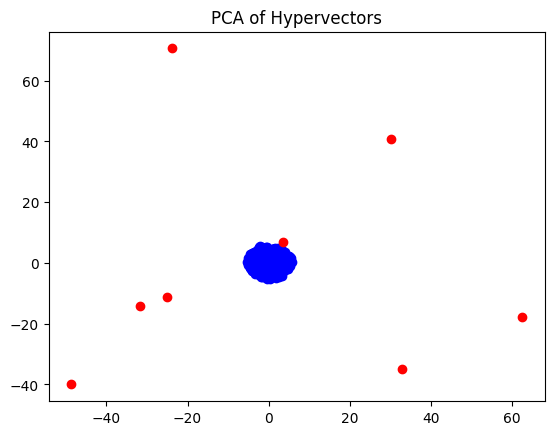

In [38]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

# Original

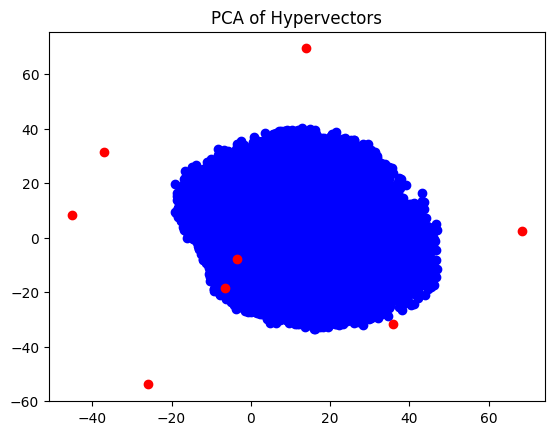

In [42]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

# Norm

#### This is PCA of London Smart Meters

In [43]:
parent = 'multipletimeseriesforecasting/preprocessed-data/'

path = os.path.join(parent, 'LondonSmartMeters/London_elec_HalfHourly.csv')

dl = DatasetLoader('LondonSmartMeters', path)

matrix_1_original = dl.dataset_load_and_preprocess("original")
matrix_1_norm = dl.dataset_load_and_preprocess("normalized")
print(matrix_1_norm.shape)

---------------------------------------------------
Dataset name:  LondonSmartMeters
Dataset contains missing values?  False
--------------------------
---------------------------------------------------
Dataset name:  LondonSmartMeters
Dataset contains missing values?  False
--------------------------
(504, 9983)


In [48]:
np.random.seed(1)
sets = np.random.choice(matrix_1_norm.shape[1]-40, int(matrix_1_norm.shape[1]*0.015), replace=False)
sets_training, sets_testing = sets[:int(len(sets)*.8)], sets[int(len(sets)*.8):]
print(sets_training, sets_testing)

[7809 1518  895  274 3329 2245 9733 2680 8824 7093  372 1433 6801 4114
 9236 2932 4638 3983 7234  825 5343 2385 5821 8316 7868 6568 2597 2844
 2373 1797 4631 9591 3085 8557 2575 7876 2122 9180 2940 6720 4997 1731
 5387  574 2311  278 2167  260 5471 9200 4171  804 4036 9427 7394 4511
 6375 6748 1967 6327 8052 6229 9620  793 5260 5142 3382 2354 4506 8244
 5569 7793 1163 9197 5358 8850  222 9204  218 8975 3709 6304  763 8232
 1510 8759 9882 2625 5220 4076 4033  408 7624 6157 5696 6790 9280 3019
 7779 9249 7239 4028 5233 8565 7308 7402 6265 8139 4220 6012 2328 5124
 4079 4453 3069 6338 9264 4600 8598] [ 625 2331 3001 5735 1475 9724 9440 4804 4221 8859 9167  954 4958 4801
 4865 8348 3942 2159 1892  619 6947 9655 6723 3067 1404 6007 9871 2247
  286 7403]


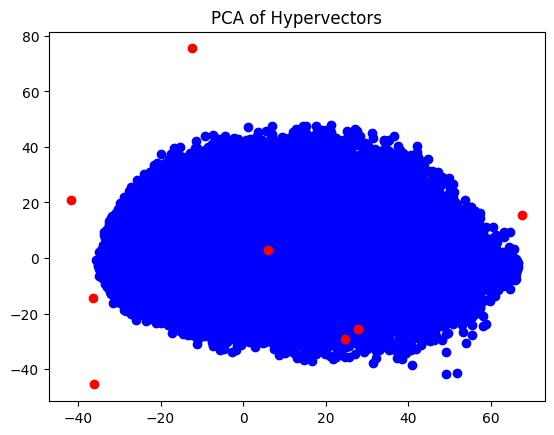

In [52]:
import matplotlib.pyplot as plt

pca_hv_x = [hv[0] for hv in pca_hv]
pca_hv_y = [hv[1] for hv in pca_hv]
pca_cl_x = [hv[0] for hv in pca_clusters]
pca_cl_y = [hv[1] for hv in pca_clusters]

plt.title("PCA of Hypervectors")
plt.plot(pca_hv_x, pca_hv_y, "bo")
plt.plot(pca_cl_x, pca_cl_y, "ro")
plt.show()

# Lets See MAE of the new encodings